In [ ]:
# using kaggle to transfer the dataset
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle && cp kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hestialyn/freshwater-fish-disease

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/hestialyn/freshwater-fish-disease
License(s): unknown
 27% 5.00M/18.8M [00:00<00:00, 48.2MB/s]
100% 18.8M/18.8M [00:00<00:00, 116MB/s] 


In [ ]:
# using zipfile to extract the zip
import zipfile
zip_ref = zipfile.ZipFile('freshwater-fish-disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# import all necessary lib
import os
import cv2
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Resizing, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
# create a list containig all classes
train_data=os.listdir('training/')
print(train_data)

['White_Tail', 'Bacterial_Aeromoniasis', 'Tail_and_Fin_Rot', 'Parasitic', 'Argulus', 'Bacterial_Gill', 'EUS', 'Bacterial_Red_Spot', 'Fungal_Saprolegniasis', 'Healthy_Fish']


In [ ]:
# get that list as a text file
with open('classes.txt', 'w') as f:
  for name in train_data:
    f.write(name)

In [ ]:
# declare starter dir
data_dir='training'
base_dir='/content/split_data'

# declare combine dir
train_dir= os.path.join(base_dir, 'train')
val_dir= os.path.join(base_dir, 'val')

# determine validation split
val_split=0.2

In [ ]:
# check whether there is a certain directory or not, if not create one
def create_split_dirs(train_dir, val_dir):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

def split_data(data_dir, train_dir, val_dir, val_split):
    create_split_dirs(train_dir, val_dir)

    # iterate over each class in the dataset
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        # making sure the current item is a directory
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            # split the image into training and validation sets
            train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

            # create corresponding class directories in the training and validation directories
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)

            # copy the training and validation images onto the class dir
            for image in train_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(train_class_dir, image))
            for image in val_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(val_class_dir, image))

split_data(data_dir, train_dir, val_dir, val_split)

In [ ]:
# simple variable to count all classes
num_classes= len(os.listdir(train_dir))

In [ ]:
# determine shape and batch size
BATCH_SIZE=32
IMG_SIZE=(150, 150)

train_set=tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE)

validation_set=tf.keras.utils.image_dataset_from_directory(val_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 1589 files belonging to 10 classes.
Found 398 files belonging to 10 classes.


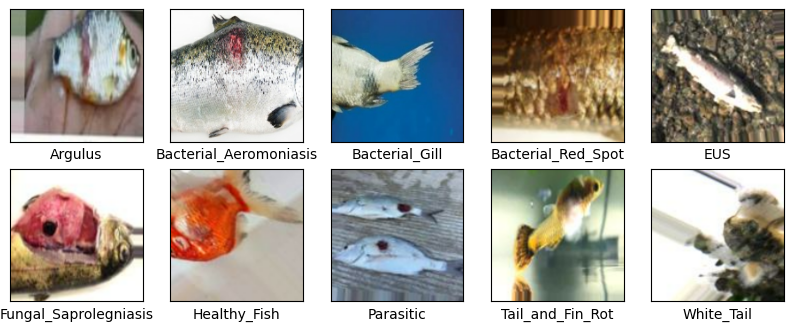

In [ ]:
# get the class names
class_name=train_set.class_names

# set up the plot size for the visualization
plt.figure(figsize=(10, 10))

# take one batch of images and labels from the training dataset
for images, labels in train_set.take(1):
  for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.xlabel(class_name[i])
plt.show()

In [ ]:
# resizing and rescaling the images
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.Rescaling(1./255.0)
])

In [ ]:
# creating a data augmentation so it become more unique
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomFlip(mode="horizontal",
                               input_shape=(IMG_SIZE[0],
                                            IMG_SIZE[1],
                                            3)),
    # tf.keras.layers.RandomContrast(0.2),
    # tf.keras.layers.RandomBrightness(0.2)
])

In [ ]:
# add the images to the batch
image = tf.cast(tf.expand_dims(images, 0), tf.float32)

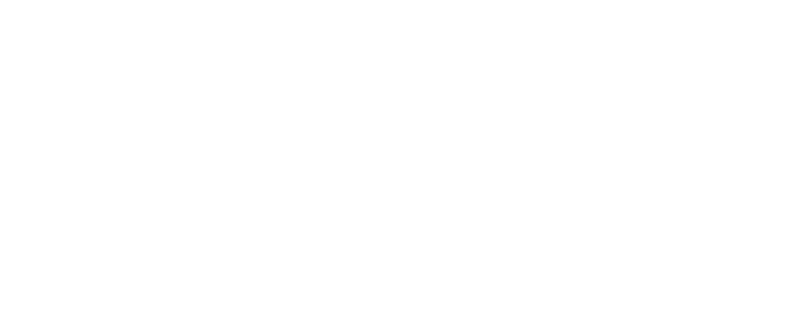

In [ ]:
# set up the plot size for the visualization
plt.figure(figsize=(10, 10))

# loop through the first 10 images
for i in range(10):
  augmented_image = data_augmentation(images)
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
plt.show()

In [ ]:
# aug_ds = train_set.map(
#   lambda x, y: (resize_and_rescale(x, training=True), y))

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# def prepare(ds, shuffle=False, augment=False):
#     # Resize and rescale all datasets.
#     ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
#                 num_parallel_calls=AUTOTUNE)

#     if shuffle:
#         ds = ds.shuffle(1000)

#     ds = ds.batch(BATCH_SIZE)

#     if augment:
#         ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
#                     num_parallel_calls=AUTOTUNE)

#     return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# train_set = prepare(train_set, shuffle=True, augment=True)
# validation_set = prepare(validation_set)

In [ ]:
"""
the model itself. include resize_rescale and data_augmentation manually
if doesnt use the previous code. simple structure not very complicated
"""
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')
])

In [ ]:
# declare the optimizers
optimizers=Adam(learning_rate=0.001)

# compiling the model and using sparse_categorical_crossentropy as the loss
model.compile(optimizer=optimizers,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# setting up the initial epochs
epochs=55

In [ ]:
# creating callbacks and reduce learning rate if necessary
callbacks=EarlyStopping(monitor='val_loss',
                        patience=5,
                        restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=1,
                            verbose=1,
                            min_lr=1e-7)

In [ ]:
# run the model itself
history=model.fit(train_set,
                  validation_data=validation_set,
                  epochs=epochs)

Epoch 1/55


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 54s 999ms/step - loss: 2.2572 - accuracy: 0.1479 - val_loss: 2.1379 - val_accuracy: 0.1985
Epoch 2/55
50/50 [==============================] - 48s 956ms/step - loss: 2.1248 - accuracy: 0.2014 - val_loss: 2.0937 - val_accuracy: 0.2437
Epoch 3/55
50/50 [==============================] - 49s 976ms/step - loss: 2.0659 - accuracy: 0.2511 - val_loss: 1.9646 - val_accuracy: 0.3090
Epoch 4/55
50/50 [==============================] - 50s 997ms/step - loss: 1.9559 - accuracy: 0.2832 - val_loss: 1.8653 - val_accuracy: 0.3769
Epoch 5/55
50/50 [==============================] - 49s 982ms/step - loss: 1.9089 - accuracy: 0.3128 - val_loss: 1.7746 - val_accuracy: 0.3869
Epoch 6/55
50/50 [==============================] - 49s 987ms/step - loss: 1.7940 - accuracy: 0.3537 - val_loss: 1.6927 - val_accuracy: 0.4372
Epoch 7/55
50/50 [==============================] - 49s 987ms/step - loss: 1.7779 - accuracy: 0.3801 - val_loss: 1.7097 - val_accuracy: 0.4322
Epoch 8/55

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

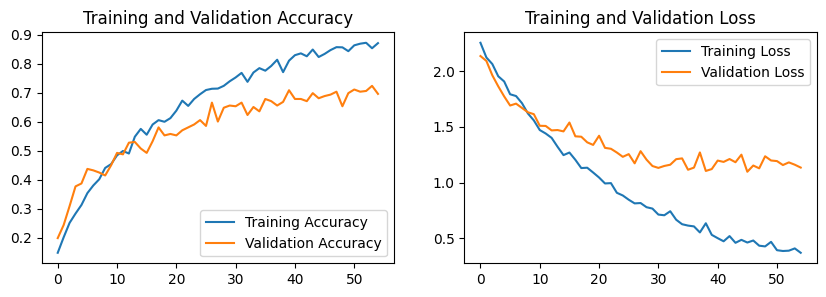

In [ ]:
# get the history for our model (since we called it history earlier it became twice)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 3))

# plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

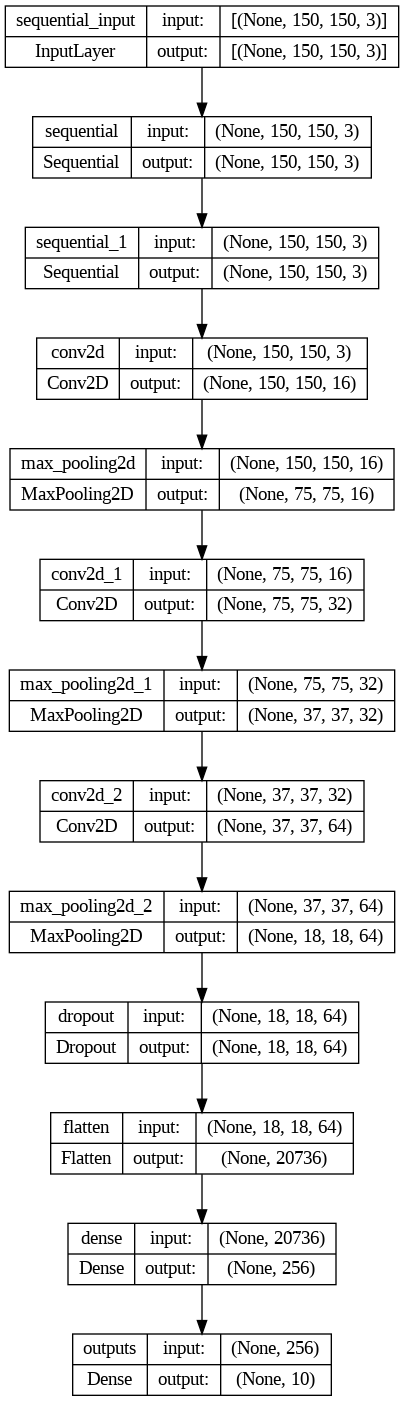

In [ ]:
# plot the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# save the model
if __name__ == '__main__':
  model=model
  model.save('model.h5')

In [34]:
model = load_model('model.h5')

def preprocess_image(image_path, target_size=(IMG_SIZE[0], IMG_SIZE[1])):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

image_path = '/content/split_data/val/Fungal_Saprolegniasis/fungal_saprolegniasis_(101).jpg'

preprocessed_image = preprocess_image(image_path)
prediction = model.predict(preprocessed_image)
print('Prediction:', prediction)

predicted_class = np.argmax(prediction, axis=1)
class_labels = ['Argulus',
                'Bacterial_Aeromoniasis',
                'Bacterial_Gill',
                'Bacterial_Red_Spot',
                'EUS',
                'Fungal_Saprolegniasis',
                'Healthy_Fish',
                'Parasitic',
                'Tail_and_Fin_Rot',
                'White_Tail']

print('Predicted class:', class_labels[predicted_class[0]])

for i, label in enumerate(class_labels):
    print(f"{label}: {prediction[0][i]:.4f}")

1/1 [==============================] - 0s 110ms/step
Prediction: [[4.05814760e-09 3.88883634e-14 3.53322822e-11 1.32211279e-02
  7.98254973e-08 7.95224607e-01 9.24364757e-03 1.10142514e-01
  1.09879526e-04 7.20580518e-02]]
Predicted class: Fungal_Saprolegniasis
Argulus: 0.0000
Bacterial_Aeromoniasis: 0.0000
Bacterial_Gill: 0.0000
Bacterial_Red_Spot: 0.0132
EUS: 0.0000
Fungal_Saprolegniasis: 0.7952
Healthy_Fish: 0.0092
Parasitic: 0.1101
Tail_and_Fin_Rot: 0.0001
White_Tail: 0.0721
